# 머신러닝 실습 - 타이타닉 생존자 예측

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

데이터 로드

In [57]:
train = pd.read_csv("./titanic/train.csv")
test = pd.read_csv("./titanic/test.csv")
submission = pd.read_csv("./titanic/submission.csv")
print(train.shape, test.shape, submission.shape)

(891, 12) (418, 11) (418, 2)


데이터 병합

In [58]:
train['TrainSplit'] = 'Train'
test['TrainSplit'] = 'Test'
data = pd.concat([train, test], axis=0)
print(data.shape)

(1309, 13)


데이터 결측값 처리

In [59]:
data['Age'] = data['Age'].fillna(data['Age'].mean())
data['Fare'] = data['Fare'].fillna(data['Fare'].mode()[0])
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

피처 수정 및 데이터 인코딩

In [60]:
# 생존확률에 영향을 줄 수 있는 피처 새로 생성
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

# 생존과 관련성이 적은 피처 제거
data.drop(['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)

# 원-핫 인코딩
data = pd.get_dummies(data, columns=['Sex', 'Embarked'], drop_first=True)

학습용 데이터, 테스트 데이터 구분

In [61]:
selected_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'Sex_male', 'Embarked_Q', 'Embarked_S']

X_train = data.loc[data['TrainSplit'] == 'Train', selected_features]
y_train = data.loc[data['TrainSplit'] == 'Train', 'Survived']
X_test = data.loc[data['TrainSplit'] == 'Test', selected_features]
print('Train 데이터셋 크기 : ', X_train.shape, y_train.shape)
print('Test 데이터셋 크기 : ', X_test.shape)

Train 데이터셋 크기 :  (891, 10) (891,)
Test 데이터셋 크기 :  (418, 10)


학습용 데이터, 테스트 데이터 분할 및 피처 스케일링

In [62]:
#데이터 분할
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True, random_state=10)

#스케일링
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

하이퍼 파라미터 튜닝

In [63]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced']
}

모델 구축 및 로지스틱 회귀 모델로 학습

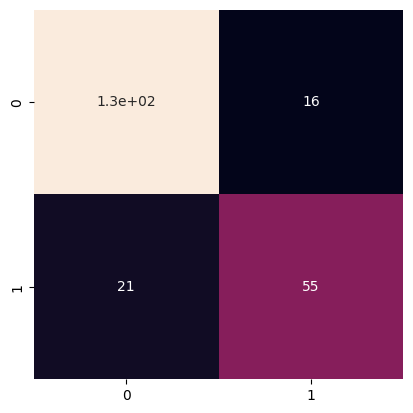

In [64]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_tr, y_tr)

best_lr_model = grid.best_estimator_
y_val_pred = best_lr_model.predict(X_val)

sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, cbar=False, square=True)
plt.show()

평가 지표 출력

In [65]:
print("Best Parameters:", grid.best_params_)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1:", f1_score(y_val, y_val_pred))
print("AUC:", roc_auc_score(y_val, y_val_pred))

Best Parameters: {'C': 0.1, 'class_weight': None, 'max_iter': 100, 'solver': 'lbfgs'}
Accuracy: 0.8340807174887892
Precision: 0.7746478873239436
Recall: 0.7236842105263158
F1: 0.7482993197278912
AUC: 0.8074203365556749


### Best Parameters
- C: 로지스틱 회귀 모델에서 규제 강도를 조절하는 파라미터. 값이 작을수록 규제가 강해지고, 값이 클수록 규제가 약해진다.
- class_weight: 클래스 불균형을 다루기 위해 사용하는 파라미터. None으로 설정해 모든 클래스에 동일한 가중치를 부여했다.
- max_iter: 최적화를 위한 최대 반복 횟수.
- solver: 최적화 알고리즘을 선택하는 파라미터. 'lbfgs'는 제한된 메모리 버전의 Broyden-Fletcher-Goldfarb-Shanno (BFGS) 알고리즘이다.

### 평가 지표
- Accuracy(정확도) : 모델이 올바르게 예측한 샘플의 비율.
- Precision(정밀도) : 모델이 양성으로 예측한 샘플 중 실제로 양성인 샘플의 비율을 나타내는 지표.
- Recall(재현율) : 실제 양성 샘플 중 모델이 양성으로 올바르게 예측한 샘플의 비율을 나타내는 지표.
- F1 : 정밀도와 재현율의 조화 평균. 정밀도와 재현율 사이의 균형을 평가하는 지표.
- AUC : ROC 곡선(수신자 조작 특성 곡선) 아래의 면적. 모델의 분류 성능을 평가하는 데 사용되는 지표로, 0.5는 랜덤 추측, 1.0은 완벽한 분류를 의미한다.